# Training Protocols for Noisy Quantum Networks

In this notebook we demo how `qnetvo` can be used to train protocols in noisy quantum networks. The protocols include superdense coding, entanglement swapping, and teleportation.


In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as qnp
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

import qnetvo

# Super Dense Coding

## Goal: Train a Superdense Coding Protocol


### 1.  Creating Network Nodes

In [8]:
# Arbitrary two-qubit pure state preparation
dense_coding_prep_nodes = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qml.ArbitraryStatePreparation,
        num_settings=6,    
    )
]

# Alice's single-qubit unitary encoding
dense_coding_proc_nodes = [
    qnetvo.ProcessingNode(
        num_in=4,
        wires=[0],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    )
]

# Bob's two-qubit measurement
dense_coding_meas_nodes = [
    qnetvo.MeasureNode(
        num_out=4,
        wires=[0,1],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=15,
    )
]


### 2. Creating Network Ansatz

The super-dense coding ansatz circuit is constructed as three layers: prepare, processing, and measure.

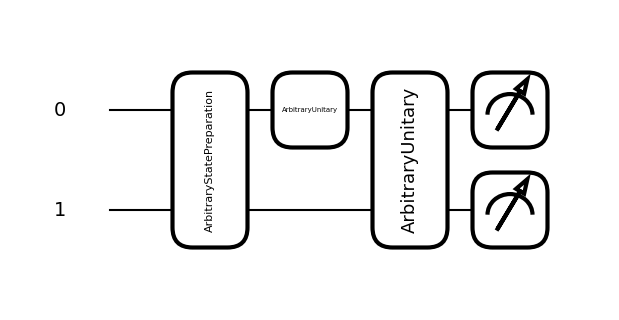

In [10]:
# construct ansatz circuit object
dense_coding_ansatz = qnetvo.NetworkAnsatz(
    dense_coding_prep_nodes,
    dense_coding_proc_nodes,
    dense_coding_meas_nodes,
)

# drawing the ansatz circuit to visualize
@qml.qnode(qml.device("default.qubit", wires=[0,1]))
def draw_circ():
    # 
    dense_coding_ansatz.fn(dense_coding_ansatz.zero_network_settings())
    return qml.probs(wires=[0,1])

qml.draw_mpl(draw_circ)();

### 3. Define Cost Function and Optimizing with Gradient Descent

Minimize the negative success probability $-P_{Success}$ over ansatz settings $\Theta $

$$
\min_{\Theta} Cost(\Theta) = - P_{Success}(\Theta)  = -\frac{1}{4}\sum_{x=0}^3 P(y=x|x, \Theta) = - \frac{1}{4}\sum_{x=0}^3 \textrm{Tr}\left[ \Pi^{A'B}_{y|\vec{\theta}}(U_{\vec{\gamma}_x}^A \otimes \mathbb{I}^B )|\psi^{AB}_{\vec{\phi}}\rangle \langle \psi^{AB}_{\vec{\phi}}|(U_{\vec{\gamma}_x}^A\otimes \mathbb{I}^B)^\dagger\right]
$$

where the settings $\Theta = \{\vec{\theta},\vec{\phi},\vec{\gamma}_0, \vec{\gamma}_1, \vec{\gamma}_2, \vec{\gamma}_3 \}$ parameterize the unitarys for state preparation, encoding, and measurement.

If the ansatz circuit's conditional probabilities $P(y|x)$ are arranged into a column stochastic matrix $\mathbf{P}(\Theta) = \sum_{x,y = 0}^3 P(y|x,\Theta) |y \rangle\langle x|$ then the cost is equivalent to $Cost(\Theta) = \textrm{Tr}[\mathbf{P}(\Theta)]$.

In [11]:
# construct the linear cost function
# the identity matrix encodes the trace operation
dense_coding_cost = qnetvo.linear_probs_cost_fn(dense_coding_ansatz, np.eye(4)/4)

dense_coding_opt_dict = qnetvo.gradient_descent(
    dense_coding_cost,
    dense_coding_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.55,
    num_steps=80,
)


iteration :  0 , score :  0.1595938063662507
elapsed time :  0.15099310874938965
iteration :  1 , score :  0.21383221175130973
elapsed time :  0.1325078010559082
iteration :  2 , score :  0.28780331620472144
elapsed time :  0.2547469139099121
iteration :  3 , score :  0.3780765159313609
elapsed time :  0.18655014038085938
iteration :  4 , score :  0.46975000915039766
elapsed time :  0.18210411071777344
iteration :  5 , score :  0.5450587884378283
elapsed time :  0.13368010520935059
iteration :  6 , score :  0.5990270545505875
elapsed time :  0.11475920677185059
iteration :  7 , score :  0.6383955920439319
elapsed time :  0.2566249370574951
iteration :  8 , score :  0.6705745600167271
elapsed time :  0.11521291732788086
iteration :  9 , score :  0.6994852782001517
elapsed time :  0.11258721351623535
iteration :  10 , score :  0.7265327484474176
elapsed time :  0.12214970588684082
iteration :  11 , score :  0.752006150312021
elapsed time :  0.10885119438171387
iteration :  12 , score :  

### 4. Adding Qubit Noise to Dense Coding Ansatz

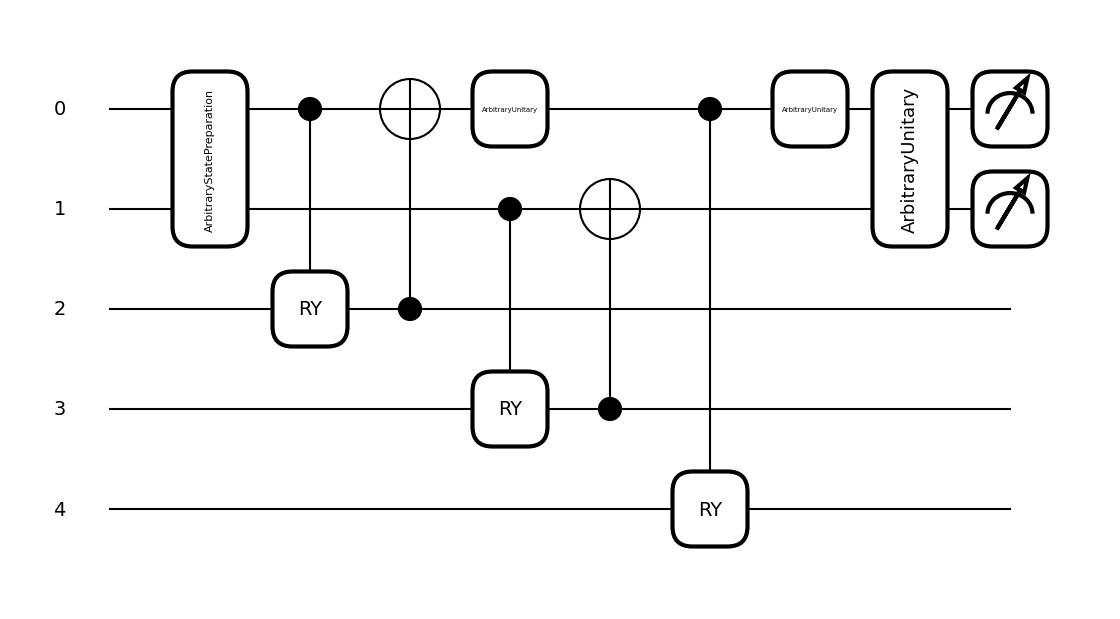

In [12]:

# nonuniform amplitude damping noise on each entangled state
qubit_amplitude_damping_nodes = [
    qnetvo.NoiseNode(wires=[0,2], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.3], wires=wires)), 
    qnetvo.NoiseNode(wires=[1,3], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.4], wires=wires)), 
]

# dephasing noise and rotation after the Alice's encoding
def dephasing_rot_noise(settings, wires):
    qnetvo.pure_phase_damping([0.3], wires=wires[0:2])
    qml.ArbitraryUnitary([0.5,0.6,0.7], wires=[wires[0]])

qubit_dephasing_noise_nodes = [
    qnetvo.NoiseNode(wires=[0,4], ansatz_fn=dephasing_rot_noise),
]

# construct noisy ansatz
noisy_dense_coding_ansatz = qnetvo.NetworkAnsatz(
    dense_coding_prep_nodes,
    qubit_amplitude_damping_nodes, # noise on state preparaation
    dense_coding_proc_nodes,
    qubit_dephasing_noise_nodes, # noise on communication
    dense_coding_meas_nodes,
)

#
@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3]))
def draw_circ():
    noisy_dense_coding_ansatz.fn(noisy_dense_coding_ansatz.zero_network_settings())

    return qml.probs(wires=[0,1])

qml.draw_mpl(draw_circ)();

### 5. Optimizing Super-Dense Coding on a Noisy Network

In [13]:
# construct super-dense coding cost
noisy_dense_coding_cost = qnetvo.linear_probs_cost_fn(noisy_dense_coding_ansatz, np.eye(4)/4)

# optimize using gradient descent
noisy_opt_dict = qnetvo.gradient_descent(
    noisy_dense_coding_cost,
    noisy_dense_coding_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.65,
    num_steps=80,
)


iteration :  0 , score :  0.25644730041086417
elapsed time :  0.1627650260925293
iteration :  1 , score :  0.27201415503168935
elapsed time :  0.17473316192626953
iteration :  2 , score :  0.2896089414714383
elapsed time :  0.25260376930236816
iteration :  3 , score :  0.30914233900653976
elapsed time :  0.15731358528137207
iteration :  4 , score :  0.33013531701772547
elapsed time :  0.14788413047790527
iteration :  5 , score :  0.3516732538442219
elapsed time :  0.40018415451049805
iteration :  6 , score :  0.3725395232724328
elapsed time :  0.15376901626586914
iteration :  7 , score :  0.39153485665970245
elapsed time :  0.1413438320159912
iteration :  8 , score :  0.407834979916433
elapsed time :  0.14135980606079102
iteration :  9 , score :  0.4211758114895915
elapsed time :  0.2508721351623535
iteration :  10 , score :  0.43178411881807355
elapsed time :  0.2884330749511719
iteration :  11 , score :  0.4401578640192794
elapsed time :  0.12725305557250977
iteration :  12 , score :

### 6. Comparing the Noisy and Noise Dense Coding Protocols

The super dense coding protocol can achieve perfect state discrimination fidelity in the noiseless case. In the noisy case, it $P_{Success}$ is just larger than the classical bound  $0.5 = P_{Success}$.

Ideal State Discrimination Success :  0.9958016348995143
Noisy Protocol in ideal Setting :  0.6609962654736716
Noisy Protocol in Noisy Setting :  0.5777590075999894
Ideal Protocol in Noisy Settings :  0.5172366644950066


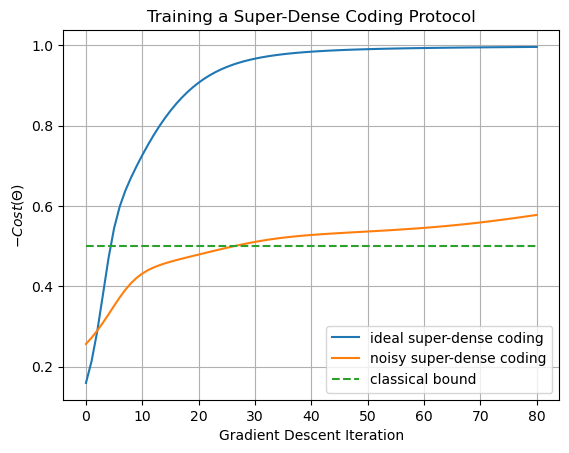

In [16]:
print("Ideal State Discrimination Success : ", dense_coding_opt_dict["opt_score"])
print("Noisy Protocol in ideal Setting : ", -dense_coding_cost(*noisy_opt_dict["opt_settings"]))
print("Noisy Protocol in Noisy Setting : ", noisy_opt_dict["opt_score"])
print("Ideal Protocol in Noisy Settings : ", -noisy_dense_coding_cost(*dense_coding_opt_dict["opt_settings"]))


plt.plot(range(len(dense_coding_opt_dict["scores"])), dense_coding_opt_dict["scores"], label="ideal super-dense coding")
plt.plot(range(len(noisy_opt_dict["scores"])), noisy_opt_dict["scores"], label="noisy super-dense coding")
plt.plot(range(len(noisy_opt_dict["scores"])), [0.5]*len(noisy_opt_dict["scores"]), "--", label="classical bound")
plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Training a Super-Dense Coding Protocol")
plt.show()

# Training a Teleportation Protocol

### 1. Define Network Nodes

In [18]:
"""
State Prepartaion
"""

entanglement_prep_node = qnetvo.PrepareNode(
    wires=[1,2], ansatz_fn=qml.ArbitraryStatePreparation, num_settings=6
)

# prepras a fixed state
def input_prep_node(state_vec):
    def circuit(settings, wires):
        qml.QubitStateVector(state_vec, wires=wires[0])

    return qnetvo.PrepareNode(wires=[0], ansatz_fn=circuit)

"""
LOCC Sender
"""

# arbitrary two-qubit measurement with two-bits of classical communication
def cc_sender_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:2])

    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])

    return [b0, b1]

cc_sender_node = qnetvo.CCSenderNode(wires=[0,1], cc_wires_out=[0,1], ansatz_fn=cc_sender_circ, num_settings=15)

"""
Classical Communication Receiver
"""

# arbitrary qubit gate conditioned uniquely on the joint two-qubit outcome
def cc_receiver_circ(settings, wires, cc_wires):
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[0:3], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 0), qml.Rot)(*settings[3:6], wires=wires[0])
    qml.cond((cc_wires[0] == 0) & (cc_wires[1] == 1), qml.Rot)(*settings[6:9], wires=wires[0])
    qml.cond((cc_wires[0] == 1) & (cc_wires[1] == 1), qml.Rot)(*settings[9:12], wires=wires[0])


cc_receiver_node = qnetvo.CCReceiverNode(wires=[2], cc_wires_in=[0,1], ansatz_fn=cc_receiver_circ, num_settings=12)

## 2. Quantifying Teleportation Success

$$
    Cost(\Theta) = -\frac{1}{N} \sum_{i=1}^N F(\rho'_{i,\Theta}, \rho_i) 
$$

where $\{\rho_i\}_{i=1}^N$ is a set of training states, $F(\cdot,\cdot)$ is the fidelity, and $\rho'_{i,\Theta}$ is the teleportated state for input $\rho_i$.

In [19]:
def cost_fn(input_states):

    # creating a collection of training states for teleportation
    input_prep_nodes = [input_prep_node(state) for state in input_states]
    
    # each state forms its own ansatz
    ansatzes = [
        qnetvo.NetworkAnsatz(
            [input_prep_node, entanglement_prep_node], # state preparation
            [cc_sender_node], # locc sender
            [cc_receiver_node], # cc_receiver
        )
        for input_prep_node in input_prep_nodes
    ]

    # output a density matrix from the circuit evaluation
    def teleport_qnode_fn(ansatz): 
        @qml.qnode(qml.device(**ansatz.dev_kwargs))
        def teleport(settings):
            ansatz.fn(settings)
            return qml.density_matrix(2)

        return teleport

    teleport_circuits = [teleport_qnode_fn(ansatz) for ansatz in ansatzes]

    # minimize average teleportation fidelity
    def cost(*settings):
        cost_val = 0
        for i in range(len(teleport_circuits)):
            teleport_circuit = teleport_circuits[i]
            input_state = input_states[i]

            rho = teleport_circuit(settings)
            rho_target = np.outer(input_state, input_state.conj())

            cost_val -= qml.math.fidelity(rho, rho_target)

        return cost_val / len(teleport_circuits)

    return cost

### 3. VQO of a Teleportation Protocol

ideal ansataz


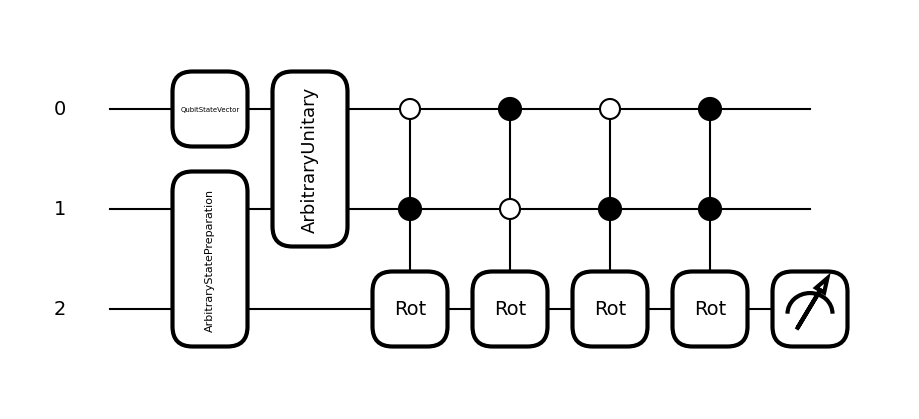

In [22]:
teleport_ansatz = qnetvo.NetworkAnsatz(
    [input_prep_node(training_states[0]), entanglement_prep_node],
    [cc_sender_node],
    [cc_receiver_node],
)
init_settings = teleport_ansatz.rand_network_settings()

print("ideal ansataz")
@qml.qnode(qml.device("default.qubit", wires=[0,1,2]))
def draw_circ():
    teleport_ansatz.fn(teleport_ansatz.zero_network_settings())

    return qml.probs(wires=[2])

qml.draw_mpl(draw_circ)();

In [23]:

training_states = [
    np.array([1, 0]),
    np.array([1, 1]) / np.sqrt(2),
    np.array([1, -1]) / np.sqrt(2),
    np.array([1, 1j]) / np.sqrt(2),
]

training_cost = cost_fn(training_states)
init_settings = teleport_ansatz.rand_network_settings()

# optimizing teleportation protocol
opt_dict = qnetvo.gradient_descent(
    training_cost,
    init_settings,
    step_size=1.6,
    num_steps=100,
    sample_width=1,
    verbose=True,
)

iteration :  0 , score :  0.40124536937526006
elapsed time :  0.18267202377319336


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


iteration :  1 , score :  0.5017777257965526
elapsed time :  0.21172595024108887
iteration :  2 , score :  0.6078555801774046
elapsed time :  0.19403886795043945
iteration :  3 , score :  0.6646393129072554
elapsed time :  0.3371896743774414
iteration :  4 , score :  0.691003736657991
elapsed time :  0.1867070198059082
iteration :  5 , score :  0.7104283082130327
elapsed time :  0.17131900787353516
iteration :  6 , score :  0.7264974111343374
elapsed time :  0.17531323432922363
iteration :  7 , score :  0.7395638492037809
elapsed time :  0.3233158588409424
iteration :  8 , score :  0.750186651678888
elapsed time :  0.16434884071350098
iteration :  9 , score :  0.7591031596901345
elapsed time :  0.17010498046875
iteration :  10 , score :  0.7669045100305327
elapsed time :  0.1945483684539795
iteration :  11 , score :  0.7739956286500385
elapsed time :  0.20814085006713867
iteration :  12 , score :  0.7806898835434135
elapsed time :  0.362994909286499
iteration :  13 , score :  0.7872916

### 4. Testing Trained Teleportation Protocol

In [24]:
# generating 100 random states to test teleportation protocol
test_states = [unitary_group.rvs(2)[:, 0] for i in range(100)]
test_cost = cost_fn(test_states)

# np.isclose(test_cost(*opt_dict["opt_settings"]), -1, atol=5e-3)
test_score = - test_cost(*opt_dict["opt_settings"])

print("test score : ", test_score)

test score :  0.9990742458897408


Finally, we plot the gradient descent optimization and the test score to show how they compare.
Since the fidelity is maximal at value one, we use (1 - Average Fidelity) to measure closeness on a logscale

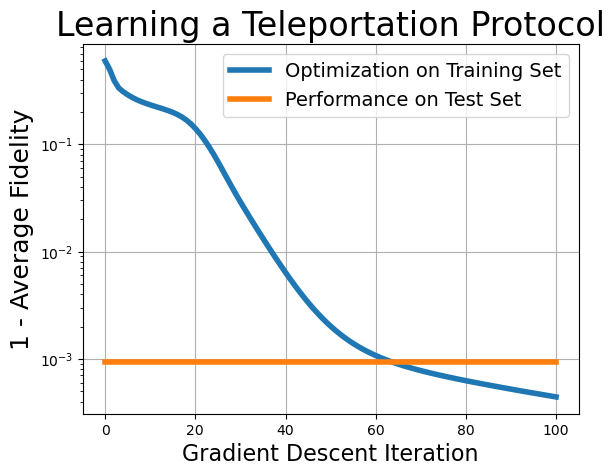

In [25]:
plt.semilogy(range(0,101), 1 - np.array(opt_dict["scores"]), label="Optimization on Training Set", linewidth=4)
plt.semilogy(range(0,101), 1 - np.array([test_score]*101), label="Performance on Test Set", linewidth=4)
plt.title("Learning a Teleportation Protocol", size=24)
plt.ylabel("1 - Average Fidelity", size=18)
plt.xlabel("Gradient Descent Iteration", size=16)
plt.grid()
plt.legend(fontsize=14)


# Training Entanglement Swapping Through a Bell Violation

### 1. Network Node Construction

In [26]:
ent_swap_prep_nodes = [
    qnetvo.PrepareNode(
        wires=[0,1],
        ansatz_fn=qnetvo.ghz_state,
    ),
    qnetvo.PrepareNode(
        wires=[2,3],
        ansatz_fn=qnetvo.ghz_state,
    ),
]

# noise on each source qubit
ent_swap_source_noise_nodes = [
    qnetvo.NoiseNode(wires=[0,4], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.1], wires=wires)),
    qnetvo.NoiseNode(wires=[1,5], ansatz_fn=lambda settings, wires: qnetvo.pure_phase_damping([0.2], wires=wires)),
    qnetvo.NoiseNode(wires=[2,6], ansatz_fn=lambda settings, wires: qnetvo.pure_phase_damping([0.1], wires=wires)),
    qnetvo.NoiseNode(wires=[3,7], ansatz_fn=lambda settings, wires: qnetvo.pure_amplitude_damping([0.2], wires=wires)),
]

# central node
def repeater_circ(settings, wires):
    qml.ArbitraryUnitary(settings, wires=wires[0:2])
    
    b0 = qml.measure(wires[0])
    b1 = qml.measure(wires[1])

    return [b0, b1]

ent_swap_repeater_node = [
    qnetvo.CCSenderNode(
        wires=[1,2],
        ansatz_fn=repeater_circ,
        num_settings=15,
        cc_wires_out=[0,1],
    )
]


# LOCC receiver
def ent_swap_cc_receiver_circ(settings, wires, cc_wires): 
    qml.cond(
        (cc_wires[0] == 0) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[0:3], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 1) & (cc_wires[1] == 0),
        qml.ArbitraryUnitary
    )(settings[3:6], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 0) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[6:9], wires=[wires[0]])
    qml.cond(
        (cc_wires[0] == 1) & (cc_wires[1] == 1),
        qml.ArbitraryUnitary
    )(settings[9:12], wires=[wires[0]])


ent_swap_receiver_node = [
    qnetvo.CCReceiverNode(
        wires=[3],
        cc_wires_in=[0,1],
        ansatz_fn=ent_swap_cc_receiver_circ,
        num_settings=12,
    )
]

ent_swap_meas_nodes = [
    qnetvo.MeasureNode(
        num_in=2,
        num_out=2,
        wires=[0],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    ),
    qnetvo.MeasureNode(
        num_in=2,
        num_out=2,
        wires=[3],
        ansatz_fn=qml.ArbitraryUnitary,
        num_settings=3,
    ),
]

(<Figure size 1100x500 with 1 Axes>, <Axes: >)

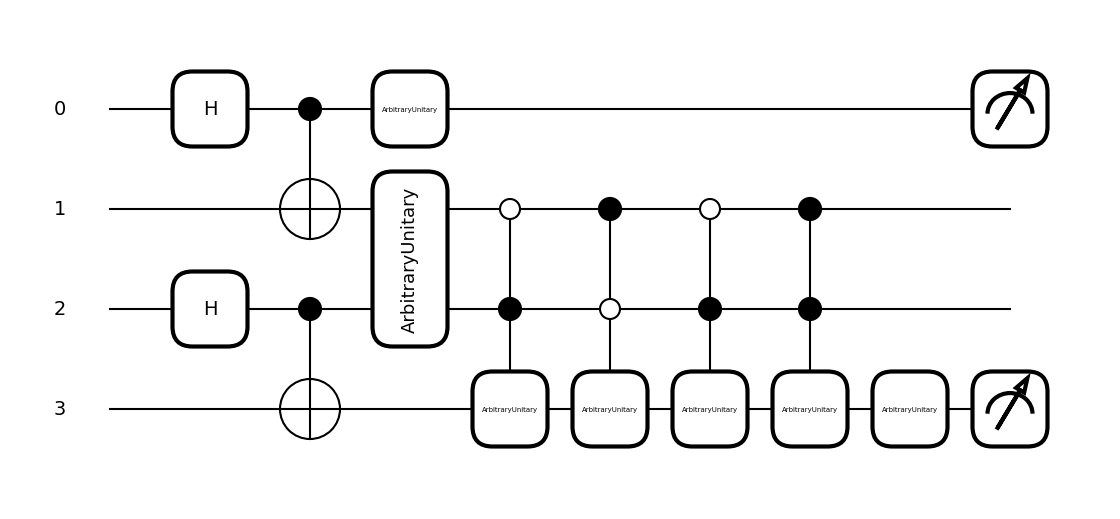

In [32]:
ideal_ent_swap_ansatz = qnetvo.NetworkAnsatz(
    ent_swap_prep_nodes,
    ent_swap_repeater_node,
    ent_swap_receiver_node,
    ent_swap_meas_nodes,
)

@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3]))
def draw_circ():
    ideal_ent_swap_ansatz.fn(ideal_ent_swap_ansatz.zero_network_settings())

    return qml.probs(wires=[0,3])

qml.draw_mpl(draw_circ)()

(<Figure size 1600x900 with 1 Axes>, <Axes: >)

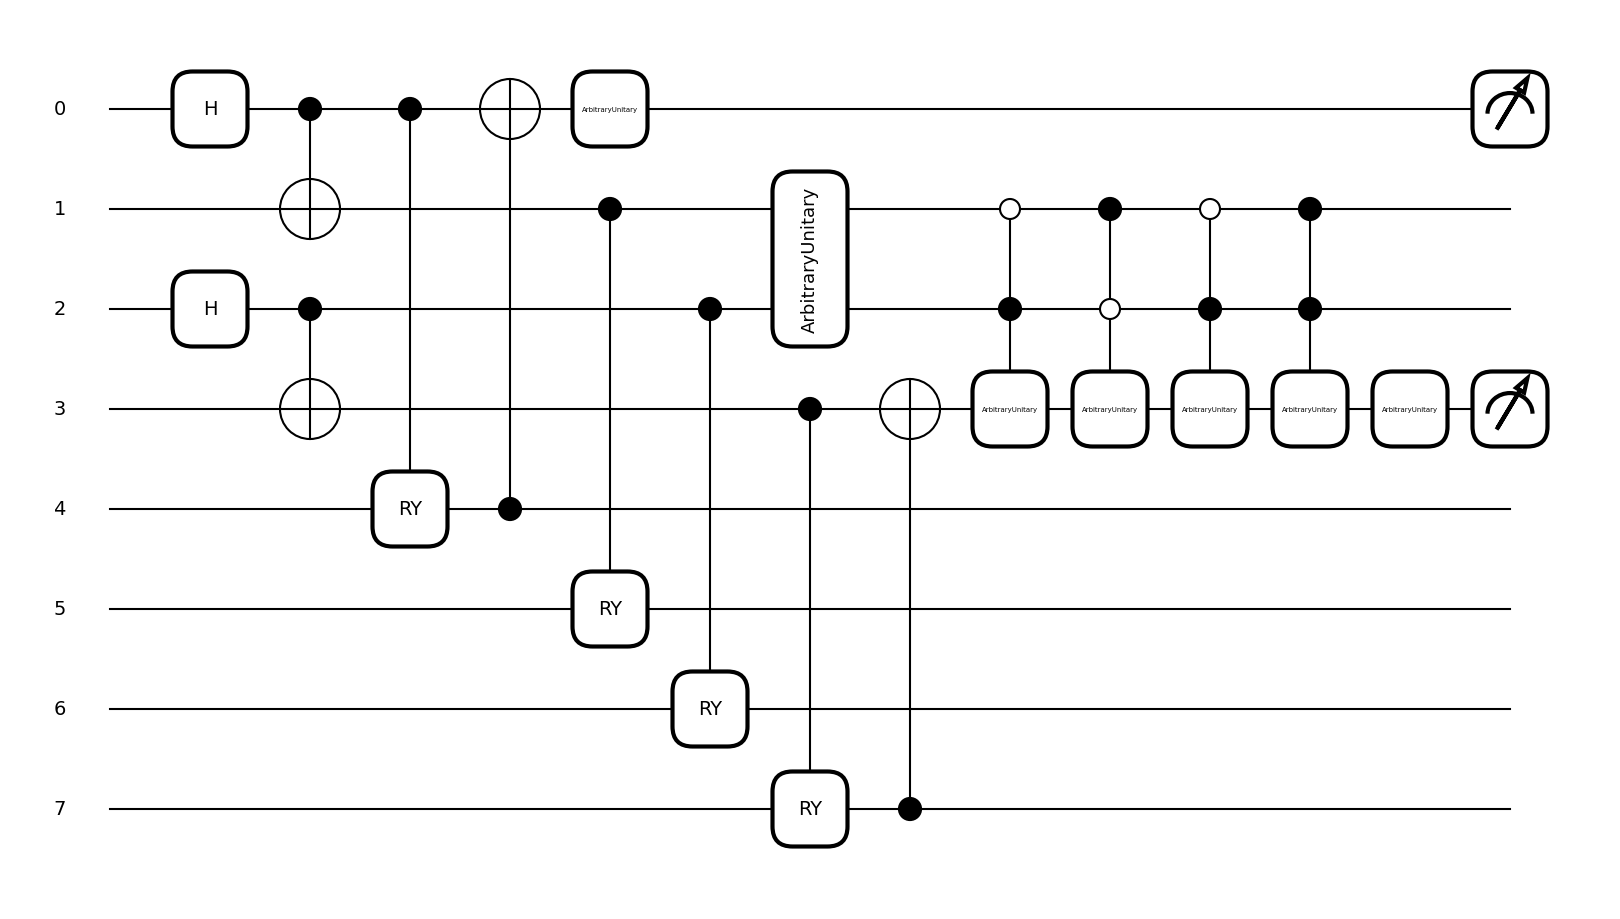

In [33]:
noisy_ent_swap_ansatz = qnetvo.NetworkAnsatz(
    ent_swap_prep_nodes,
    ent_swap_source_noise_nodes,
    ent_swap_repeater_node,
    ent_swap_receiver_node,
    ent_swap_meas_nodes,
)

@qml.qnode(qml.device("default.qubit", wires=[0,1,2,3,4,5,6,7]))
def draw_circ():
    noisy_ent_swap_ansatz.fn(noisy_ent_swap_ansatz.zero_network_settings())

    return qml.probs(wires=[0,3])

qml.draw_mpl(draw_circ)()

### Maximizing CHSH violation in Entanglement swapping

$$
    Cost(\Theta) = - S_{CHSH}(\Theta) = - \sum_{x,y\in\{0,1\}} (-1)^{xy}\langle A_{\vec{\theta}_x} B_{\vec{\theta}_y} \rangle_{\rho^{AB}_{\vec{\phi}}}
$$

In [34]:
noisy_chsh_cost = qnetvo.chsh_inequality_cost_fn(noisy_ent_swap_ansatz)
ideal_chsh_cost = qnetvo.chsh_inequality_cost_fn(ideal_ent_swap_ansatz)

In [35]:
np.random.seed(44)
ideal_ent_swap_opt_dict = qnetvo.gradient_descent(
    ideal_chsh_cost,
    ideal_ent_swap_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.25,
    num_steps=80,
)

noisy_ent_swap_opt_dict = qnetvo.gradient_descent(
    noisy_chsh_cost,
    noisy_ent_swap_ansatz.rand_network_settings(),
    verbose=True,
    sample_width=1,
    step_size=0.25,
    num_steps=80,
)

iteration :  0 , score :  0.5629050814997851
elapsed time :  0.2596890926361084
iteration :  1 , score :  1.05979304840615
elapsed time :  0.41294193267822266
iteration :  2 , score :  1.3885932030102248
elapsed time :  0.25954389572143555
iteration :  3 , score :  1.588319184881591
elapsed time :  0.22839713096618652
iteration :  4 , score :  1.7149629321011746
elapsed time :  0.2358570098876953
iteration :  5 , score :  1.7984693848240205
elapsed time :  0.3869178295135498
iteration :  6 , score :  1.8533817050847485
elapsed time :  0.2040269374847412
iteration :  7 , score :  1.8895659865604046
elapsed time :  0.21910810470581055
iteration :  8 , score :  1.9141044741415103
elapsed time :  0.2673490047454834
iteration :  9 , score :  1.931616588626531
elapsed time :  0.3807802200317383
iteration :  10 , score :  1.9448610006447153
elapsed time :  0.291323184967041
iteration :  11 , score :  1.9554133088571346
elapsed time :  0.24128198623657227
iteration :  12 , score :  1.964175891

ideal settings noisy network :  1.9917510876992264
noisy optimum :  2.0722230063324423


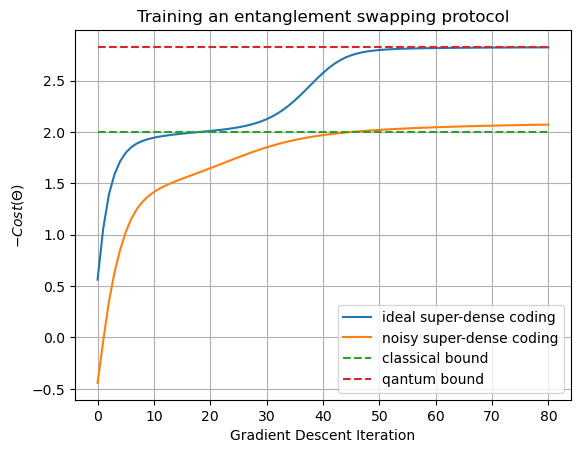

In [36]:
print("ideal settings noisy network : ", -noisy_chsh_cost(*ideal_ent_swap_opt_dict["opt_settings"]))
print("noisy optimum : ", noisy_ent_swap_opt_dict["opt_score"])

plt.plot(range(len(ideal_ent_swap_opt_dict["scores"])), ideal_ent_swap_opt_dict["scores"], label="ideal super-dense coding")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), noisy_ent_swap_opt_dict["scores"], label="noisy super-dense coding")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), [2]*len(noisy_ent_swap_opt_dict["scores"]), "--", label="classical bound")
plt.plot(range(len(noisy_ent_swap_opt_dict["scores"])), [2*qml.math.sqrt(2)]*len(noisy_ent_swap_opt_dict["scores"]), "--", label="qantum bound")

plt.grid()

plt.xlabel("Gradient Descent Iteration")
plt.ylabel(r"$-Cost(\Theta)$")
plt.legend()
plt.title("Training an entanglement swapping protocol")
plt.show()

## Star Network Entanglement Distribution

In [37]:
def star_prep_nodes(n):
    return [
        qnetvo.PrepareNode(wires=[i,n+i], ansatz_fn=qnetvo.ghz_state)
        for i in range(n)
    ]


def star_repeater_nodes(n):
    
    def star_repeater_ansatz(settings, wires):

        for i in range(1,n):
            qml.CNOT(wires=[wires[0],wires[i]]) 

        qml.Hadamard(wires=wires[0])

        measurements = []
        for i in range(n):
            measurements += [qml.measure(wires[i])]

        return measurements
    
    return [
        qnetvo.CCSenderNode(
            wires=range(n,2*n),
            cc_wires_out=range(n),
            ansatz_fn=star_repeater_ansatz,
        )
    ]


def star_receiver_nodes(n):

    def star_receiver_node_fn(settings, wires, cc_wires):
        for i in range(n):
            qml.cond(cc_wires[i] == 1, qml.ArbitraryUnitary)(settings[3*i:3*i+3], wires=[wires[0]])

    return [
        qnetvo.CCReceiverNode(
        wires=[i],
        cc_wires_in=range(n),
        ansatz_fn=star_receiver_node_fn,
        num_settings=3*n,
    )
        for i in range(1,n)
    ]



In [38]:
n=4

star_entanglement_distribution_ansatz = qnetvo.NetworkAnsatz(
    star_prep_nodes(n),
    star_repeater_nodes(n),
    star_receiver_nodes(n),
)

@qml.qnode(qml.device("default.qubit", wires=range(2*n)))
def star_teleportation(settings):
    star_entanglement_distribution_ansatz.fn(settings)

    return qml.density_matrix(wires=range(n))

def star_teleportation_cost_fn(n):
    def star_teleportation_cost(*settings):
        match_state = np.zeros((2**n,2**n))
        match_state[0,0] = 1/2
        match_state[2**n-1,2**n-1] = 1/2
        match_state[0,2**n-1] = 1/2
        match_state[2**n-1,0] = 1/2

        rho = star_teleportation(settings)


        return -1 * qml.math.fidelity(rho, match_state)
    
    return star_teleportation_cost

init_settings = star_entanglement_distribution_ansatz.rand_network_settings()
star_teleportation_opt_dict = qnetvo.gradient_descent(
    star_teleportation_cost_fn(n),
    init_settings,
    verbose=True,
    sample_width=1,
    step_size=1.5,
    num_steps=150,
)

iteration :  0 , score :  0.17184494982742296
elapsed time :  0.08745312690734863
iteration :  1 , score :  0.19096329858726102
elapsed time :  0.07176971435546875


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  return A.astype(dtype, order, casting, subok, copy)


iteration :  2 , score :  0.21221727106553892
elapsed time :  0.07155179977416992
iteration :  3 , score :  0.23479248876026987
elapsed time :  0.23418688774108887
iteration :  4 , score :  0.2576595014212362
elapsed time :  0.06754708290100098
iteration :  5 , score :  0.2799515405914124
elapsed time :  0.07004022598266602
iteration :  6 , score :  0.301168973338284
elapsed time :  0.07381606101989746
iteration :  7 , score :  0.3211556732248546
elapsed time :  0.07170701026916504
iteration :  8 , score :  0.3400178275739826
elapsed time :  0.0762178897857666
iteration :  9 , score :  0.35804149714128963
elapsed time :  0.06966996192932129
iteration :  10 , score :  0.3755910677656212
elapsed time :  0.06870794296264648
iteration :  11 , score :  0.39301282507841007
elapsed time :  0.07056498527526855
iteration :  12 , score :  0.4105746690163597
elapsed time :  0.06916999816894531
iteration :  13 , score :  0.4284459091279136
elapsed time :  0.0714879035949707
iteration :  14 , score

/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:99: RuntimeWarning: invalid value encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


elapsed time :  0.06905794143676758
iteration :  124 , score :  0.9999998445269391
elapsed time :  0.06991195678710938
iteration :  125 , score :  0.99999989210878
elapsed time :  0.06956791877746582
iteration :  126 , score :  0.9999999008748068
elapsed time :  0.06952619552612305
iteration :  127 , score :  0.9999999244201604
elapsed time :  0.06961584091186523
iteration :  128 , score :  0.9999999373295939
elapsed time :  0.06785988807678223
iteration :  129 , score :  0.9999999647552901
elapsed time :  0.07243108749389648
iteration :  130 , score :  0.999999966963131
elapsed time :  0.08469390869140625
iteration :  131 , score :  0.9999999866179081
elapsed time :  0.08094310760498047
iteration :  132 , score :  0.9999999964680915
elapsed time :  0.23816895484924316
iteration :  133 , score :  1.0000000060637237
elapsed time :  0.06864380836486816
iteration :  134 , score :  1.0000000092916657
elapsed time :  0.0704498291015625
iteration :  135 , score :  0.9999999975317564
elapsed 

# entanglement assisted classical communication

In [39]:
eacc_prep_node = [
    qnetvo.PrepareNode(
        wires=[0,1],
        # ansatz_fn=qnetvo.ghz_state,
    ),
]

def ea_encoder(settings, wires):

    qml.ArbitraryUnitary(settings, wires=wires)
    
    b0 = qml.measure(wires[0])

    return [b0]

ea_sender_node = [
    qnetvo.CCSenderNode(
        wires=[0],
        cc_wires_out=[0],
        num_in=4,
        ansatz_fn=ea_encoder,
        num_settings=3,
    ),
]

def ea_decoder(settings, wires, cc_wires):

    qml.cond(
        cc_wires[0] == 0,
        qml.ArbitraryUnitary,
    )(settings[0:15], wires=wires[0:2])

    qml.cond(
        cc_wires[0] == 1,
        qml.ArbitraryUnitary,
    )(settings[15:30], wires=wires[0:2])


ea_decoder_node = [
    qnetvo.CCReceiverNode(
        wires=[1,2],
        cc_wires_in=[0],
        num_settings=30,
        ansatz_fn=ea_decoder,
    )
]



ea_measure_node = [
    qnetvo.MeasureNode(
        wires=[1,2],
        num_out=4,        
    )
]
eacc_ansatz = qnetvo.NetworkAnsatz(
    eacc_prep_node,
    ea_sender_node,
    ea_decoder_node,
    ea_measure_node,
)

eacc_cost = qnetvo.linear_probs_cost_fn(
    eacc_ansatz,
    np.eye(4),
)
init_settings = eacc_ansatz.rand_network_settings()

eacc_opt_dict = qnetvo.gradient_descent(
    eacc_cost,
    init_settings,
    sample_width=1,
    step_size=1,
    num_steps=50,
    verbose=True,
)

iteration :  0 , score :  1.0395643948851199
elapsed time :  0.3289947509765625
iteration :  1 , score :  1.2858415738908717
elapsed time :  0.5121572017669678
iteration :  2 , score :  1.5201238598024818
elapsed time :  0.2641620635986328
iteration :  3 , score :  1.7086819409992513
elapsed time :  0.5402858257293701
iteration :  4 , score :  1.827474545518566
elapsed time :  0.26761698722839355
iteration :  5 , score :  1.898406685730653
elapsed time :  0.7302501201629639
iteration :  6 , score :  1.9393092122477973
elapsed time :  0.484752893447876
iteration :  7 , score :  1.9632694600205887
elapsed time :  0.2518270015716553
iteration :  8 , score :  1.9777420144872135
elapsed time :  0.2522871494293213
iteration :  9 , score :  1.986593656120575
elapsed time :  0.6274611949920654
iteration :  10 , score :  1.9919760000971194
elapsed time :  0.25440001487731934
iteration :  11 , score :  1.9952075645526455
elapsed time :  0.42171192169189453
iteration :  12 , score :  1.9971268005